In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob 
import keras
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color as scc

from skimage import io
from random import randint
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator as ID
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [4]:
dataset_path = r'C:\Users\Sriya Nukala\Downloads\Dataset1\gaussian_filtered_images'
filepaths=[]
labels=[]

In [5]:
folds = os.listdir(dataset_path)

In [6]:
folds

['export.pkl', 'Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [7]:
for fold in folds:
    foldpath = os.path.join(dataset_path, fold)  
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

In [8]:
img_paths = pd.Series(filepaths, name= 'filepaths')
img_labels = pd.Series(labels, name='labels')
dataset = pd.concat([img_paths, img_labels], axis= 1)

In [9]:
dataset

filepaths  labels
0     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
1     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
2     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
3     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
4     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
...                                                 ...     ...
3657  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3658  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3659  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3660  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3661  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe

[3662 rows x 2 columns]

In [10]:
batch_size=3662
img=224
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

gen=ID()
data_gen = gen.flow_from_dataframe( dataset,x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 3662 validated image filenames belonging to 5 classes.


In [11]:
img_data, img_labels = data_gen.next()

In [12]:
print(img_data.shape, img_labels.shape)

(3662, 224, 224, 3) (3662, 5)


In [13]:
img_labels

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

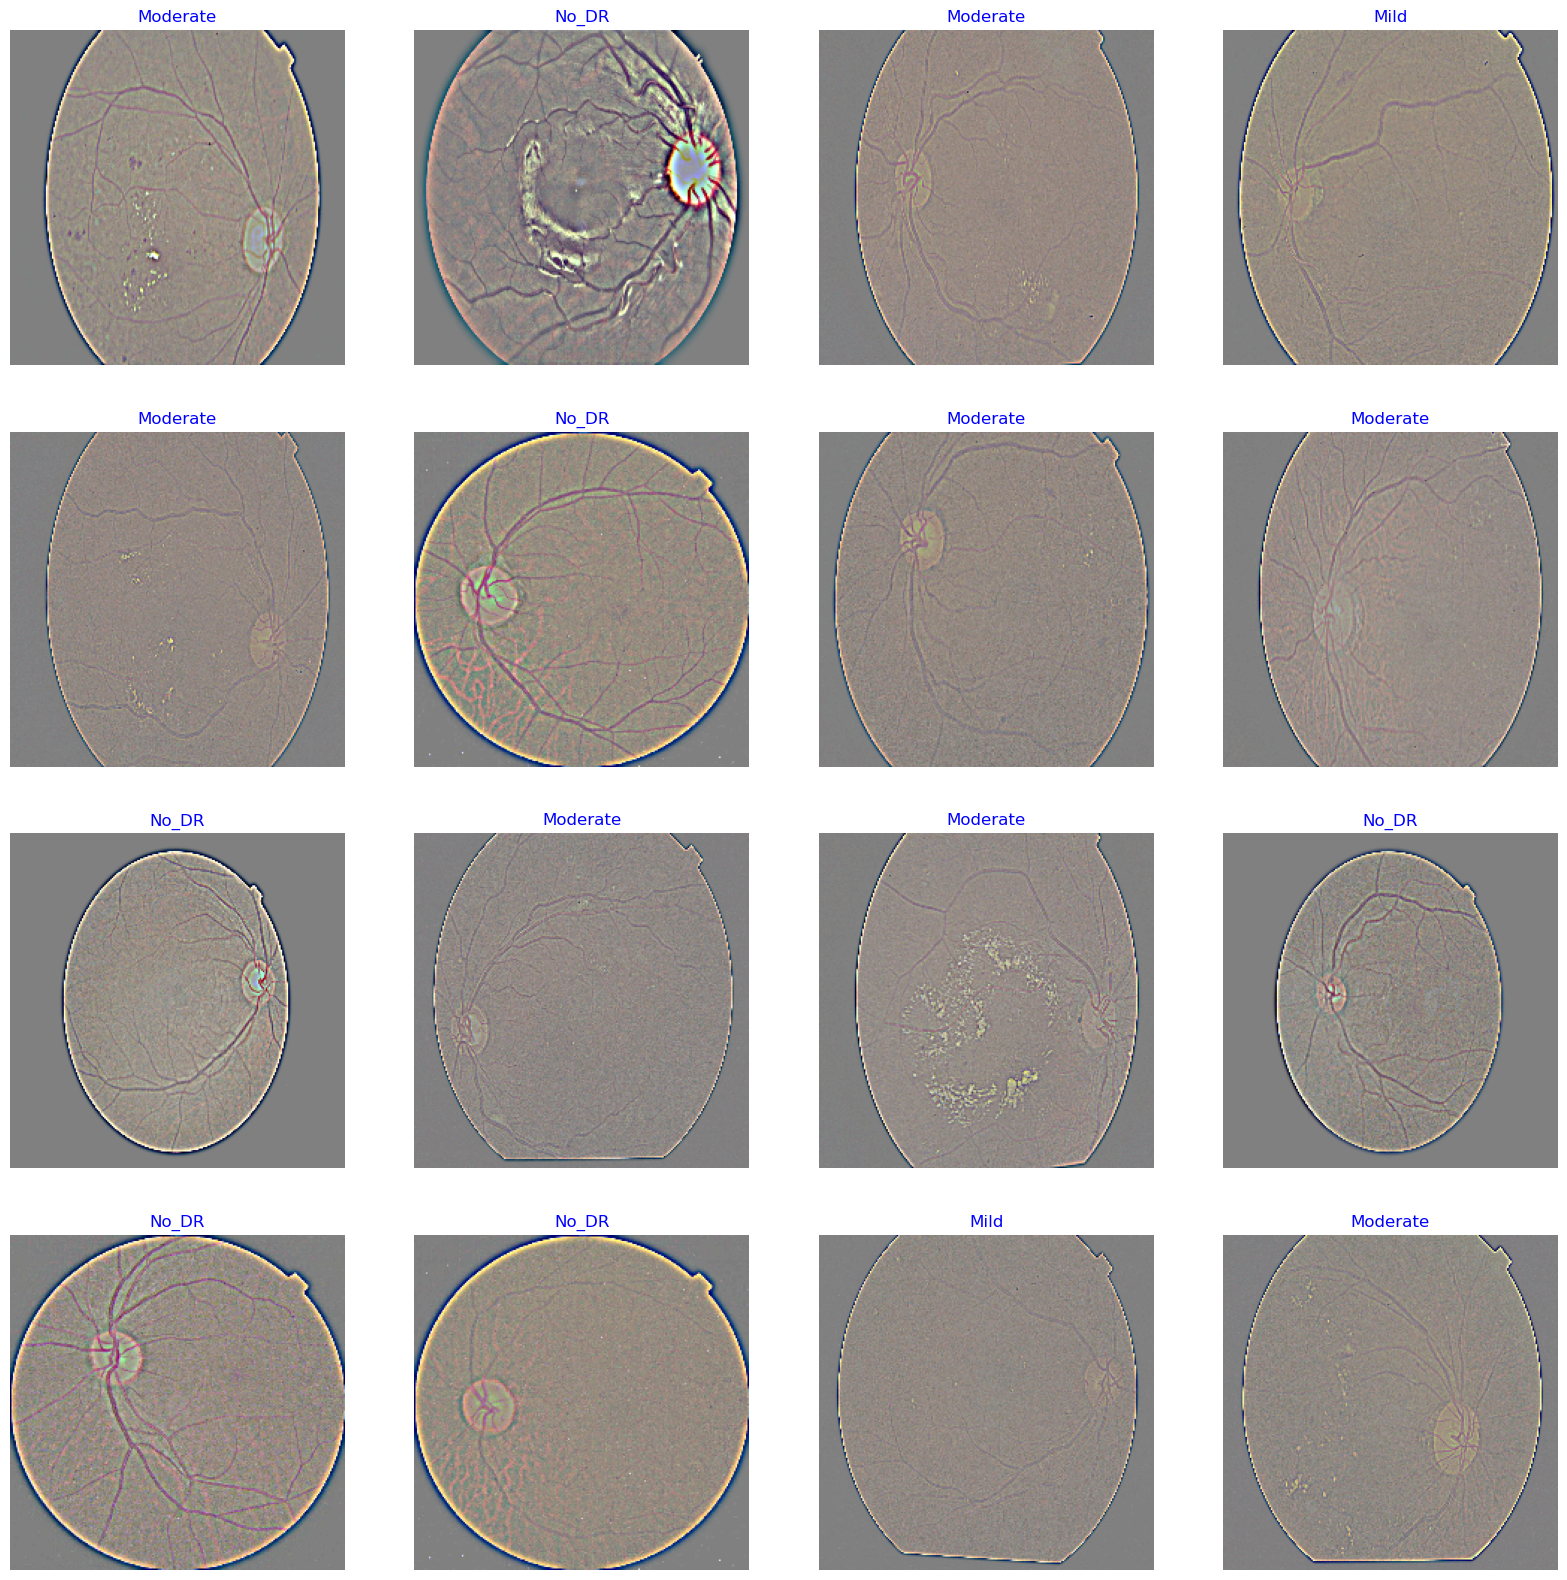

In [14]:
g_dict = data_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(data_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(img_data, img_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.25, random_state=42)

In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.models import Model
from keras.layers import LSTM, TimeDistributed,Bidirectional

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [19]:
from tensorflow.keras import layers

In [20]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [19]:
# enetb3 = EfficientNetB3(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
# for layer in enetb3.layers:
#     layer.trainable = False
# x = TimeDistributed(LSTM(32,activation="sigmoid",return_sequences=False))(enetb3.output)
# x = Dropout(0.5)(x)
# x = Flatten()(x)
# x = Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(x) 
# x = Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(x)
# x = Dropout(0.5)(x)
# x = Dense(5, activation = 'softmax')(x) 
# model = Model(inputs = enetb3.input, outputs = x)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

In [23]:
history = model.fit(train_data,train_labels, epochs= 20,verbose= 1, validation_data= (val_data,val_labels), 
                    validation_steps= None, shuffle= False,batch_size=32)

Epoch 1/20
65/65 [==============================] - 21s 299ms/step - loss: 1.6913 - Accuracy: 0.3711 - AUC: 0.6829 - f1_score: 0.2422 - val_loss: 1.6963 - val_Accuracy: 0.4847 - val_AUC: 0.7122 - val_f1_score: 0.1543
Epoch 2/20
65/65 [==============================] - 18s 274ms/step - loss: 1.0520 - Accuracy: 0.5993 - AUC: 0.8558 - f1_score: 0.3347 - val_loss: 1.3146 - val_Accuracy: 0.4920 - val_AUC: 0.7722 - val_f1_score: 0.1421
Epoch 3/20
65/65 [==============================] - 18s 274ms/step - loss: 0.9417 - Accuracy: 0.6581 - AUC: 0.8852 - f1_score: 0.3614 - val_loss: 1.1452 - val_Accuracy: 0.4949 - val_AUC: 0.8249 - val_f1_score: 0.1478
Epoch 4/20
65/65 [==============================] - 18s 280ms/step - loss: 0.8916 - Accuracy: 0.6722 - AUC: 0.8972 - f1_score: 0.3697 - val_loss: 0.9899 - val_Accuracy: 0.5852 - val_AUC: 0.8641 - val_f1_score: 0.2655
Epoch 5/20
65/65 [==============================] - 18s 279ms/step - loss: 0.8506 - Accuracy: 0.6897 - AUC: 0.9066 - f1_score: 0.392

In [24]:
train_scores = model.evaluate(train_data, train_labels)
test_scores = model.evaluate(test_data,test_labels)
val_scores = model.evaluate(val_data, val_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))

22/22 [==============================] - 2s 65ms/step - loss: 0.7523 - Accuracy: 0.7074 - AUC: 0.9276 - f1_score: 0.4139
Training Accuracy: 79.46%
Testing Accuracy: 72.71%
Validation Accuracy: 70.74%


In [24]:
img_path=r'C:\Users\Sriya Nukala\Downloads\Dataset1\gaussian_filtered_images\Severe\f6f433f3306f.png'

In [34]:
import cv2

In [35]:
img = cv2.imread(img_path)
resized_img = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

In [37]:
img = tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224,3))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255

In [39]:
img=preprocess_input(img)

NameError: name 'preprocess_input' is not defined

In [38]:
predictions = model.predict(img)

InvalidArgumentError: Graph execution error:

Detected at node model/dense/Relu defined at (most recent call last):
  File "C:\Users\Sriya Nukala\anaconda3\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\Sriya Nukala\anaconda3\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Sriya Nukala\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\Sriya Nukala\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once

  File "C:\Users\Sriya Nukala\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code

  File "C:\Users\Sriya Nukala\AppData\Local\Temp\ipykernel_16972\775165814.py", line 1, in <module>

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\activations.py", line 306, in relu

  File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [1,32], In[1]: [224,128]
	 [[{{node model/dense/Relu}}]] [Op:__inference_predict_function_50180]

In [30]:
score = predictions[0]
score

array([5.2009029e-03, 2.8876653e-01, 1.4199656e-04, 2.6034412e-01,
       4.4554657e-01], dtype=float32)

In [31]:
print("This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
model.predict()

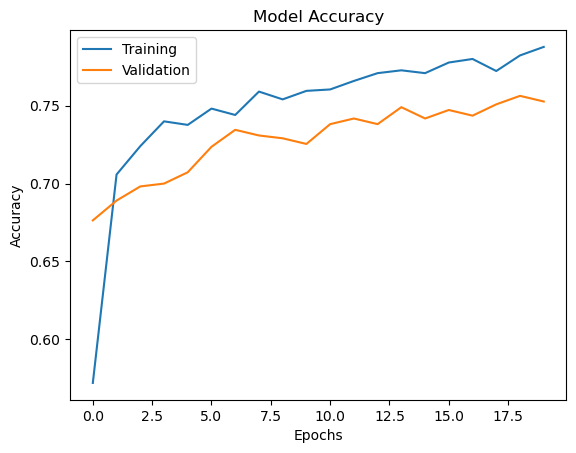

In [21]:
fig, ax = plt.subplots()
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Accuracy_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

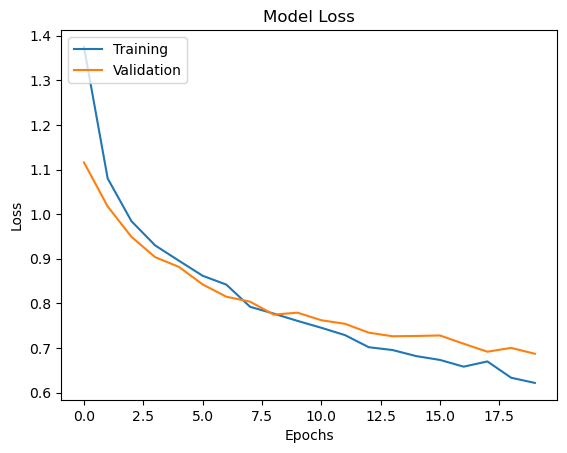

In [22]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Loss_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

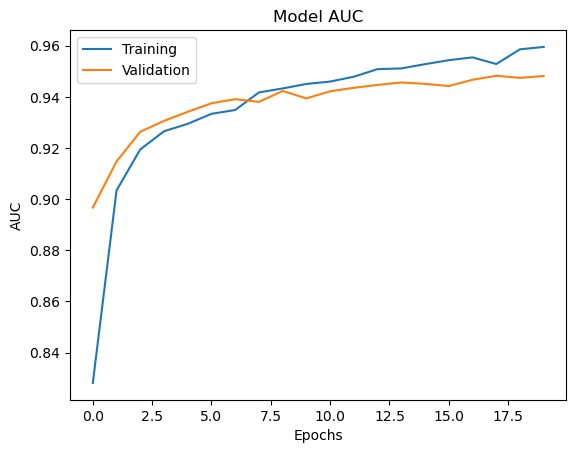

In [23]:
fig, ax = plt.subplots()
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model AUC_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

In [24]:
pred_labels = model.predict(test_data)

29/29 [==============================] - 79s 3s/step


In [25]:
from sklearn import metrics
auc = metrics.roc_auc_score(test_labels,pred_labels,multi_class='ovo')
auc

0.9154065337084475

In [26]:
auc

0.9154065337084475

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
conf_arr

array([[ 49,  29,   8,   0,   0],
       [ 11, 229,   8,   0,   0],
       [  9,   2, 449,   0,   0],
       [  4,  69,   1,   0,   0],
       [  1,  47,   0,   0,   0]], dtype=int64)

In [29]:
CLASSES=['No_DR','Mild','Moderate','Severe','Proliferate_DR']

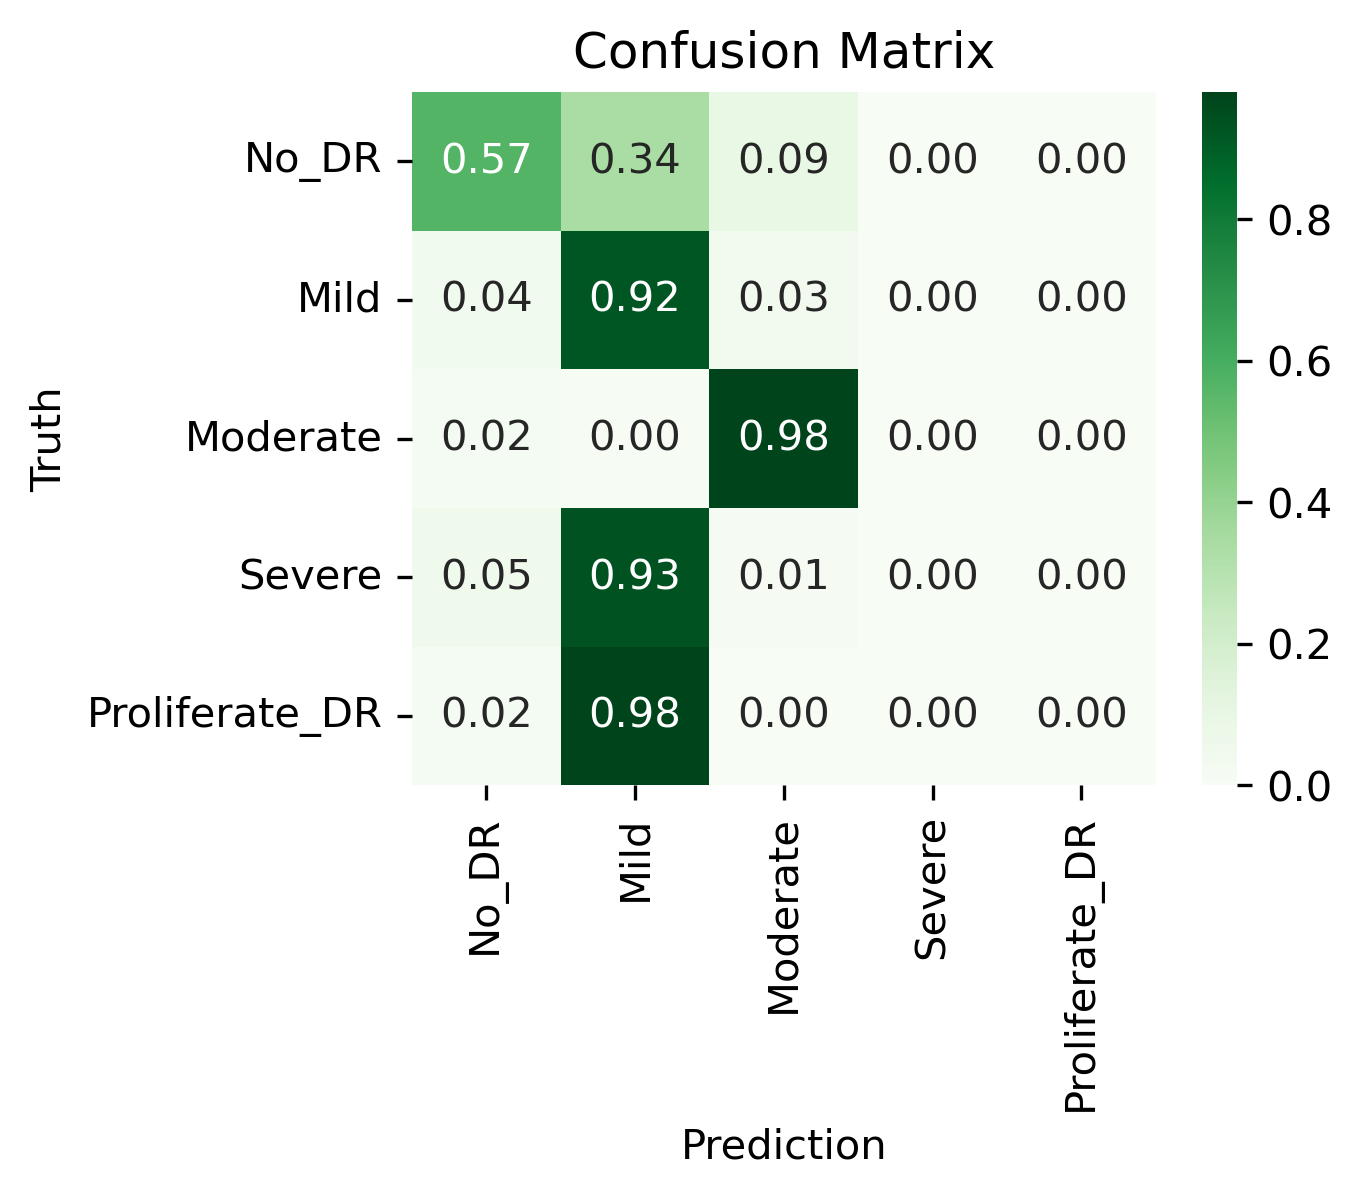

In [30]:
# pred_ls = np.argmax(pred_labels, axis=1)
# test_ls = np.argmax(test_labels, axis=1)

# conf_arr = confusion_matrix(test_ls, pred_ls)
cmn = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
fig=plt.figure(figsize=(4,3), dpi=300, facecolor='w', edgecolor='k')

ax = sns.heatmap(cmn, cmap='Greens', annot=True, fmt=".2f", xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
ax.figure.savefig('confmatrix_ENETB3-79.5.png', format='png', dpi=300)

In [31]:
pred_labels1=np.argmax(pred_labels,axis=1)
test_labels1=np.argmax(test_labels,axis=1)

In [32]:
from sklearn.preprocessing import label_binarize

In [33]:
predlabels_new=label_binarize(pred_labels1,classes=np.unique(pred_labels1))
classes=np.unique(pred_labels1)

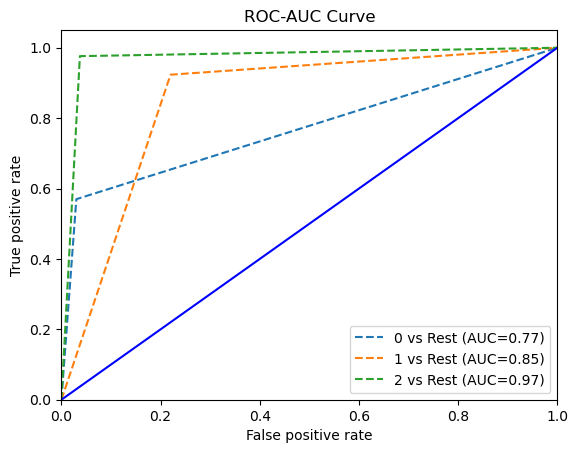

In [34]:
fig, ax = plt.subplots()
f_p_r=dict()
t_p_r = dict()
thres=dict()
rocauc_curve= dict()
total_no_of_class = classes.shape[0]
for i in range(total_no_of_class):    
    f_p_r[i], t_p_r[i], thres[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    rocauc_curve[i] = metrics.auc(f_p_r[i], t_p_r[i])    
    plt.plot(f_p_r[i], t_p_r[i], linestyle='--',label='%s vs Rest (AUC=%0.2f)'%(classes[i],rocauc_curve[i]))

plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC-AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('ROCAUC_EfficientNetB3-79.5.png', format='png', dpi=300)

In [35]:
from sklearn.metrics import classification_report

In [36]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                precision    recall  f1-score   support

         No_DR       0.66      0.57      0.61        86
          Mild       0.61      0.92      0.73       248
      Moderate       0.96      0.98      0.97       460
        Severe       0.00      0.00      0.00        74
Proliferate_DR       0.00      0.00      0.00        48

     micro avg       0.79      0.79      0.79       916
     macro avg       0.45      0.49      0.46       916
  weighted avg       0.71      0.79      0.74       916
   samples avg       0.79      0.79      0.79       916



C:\Users\SNEHA\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


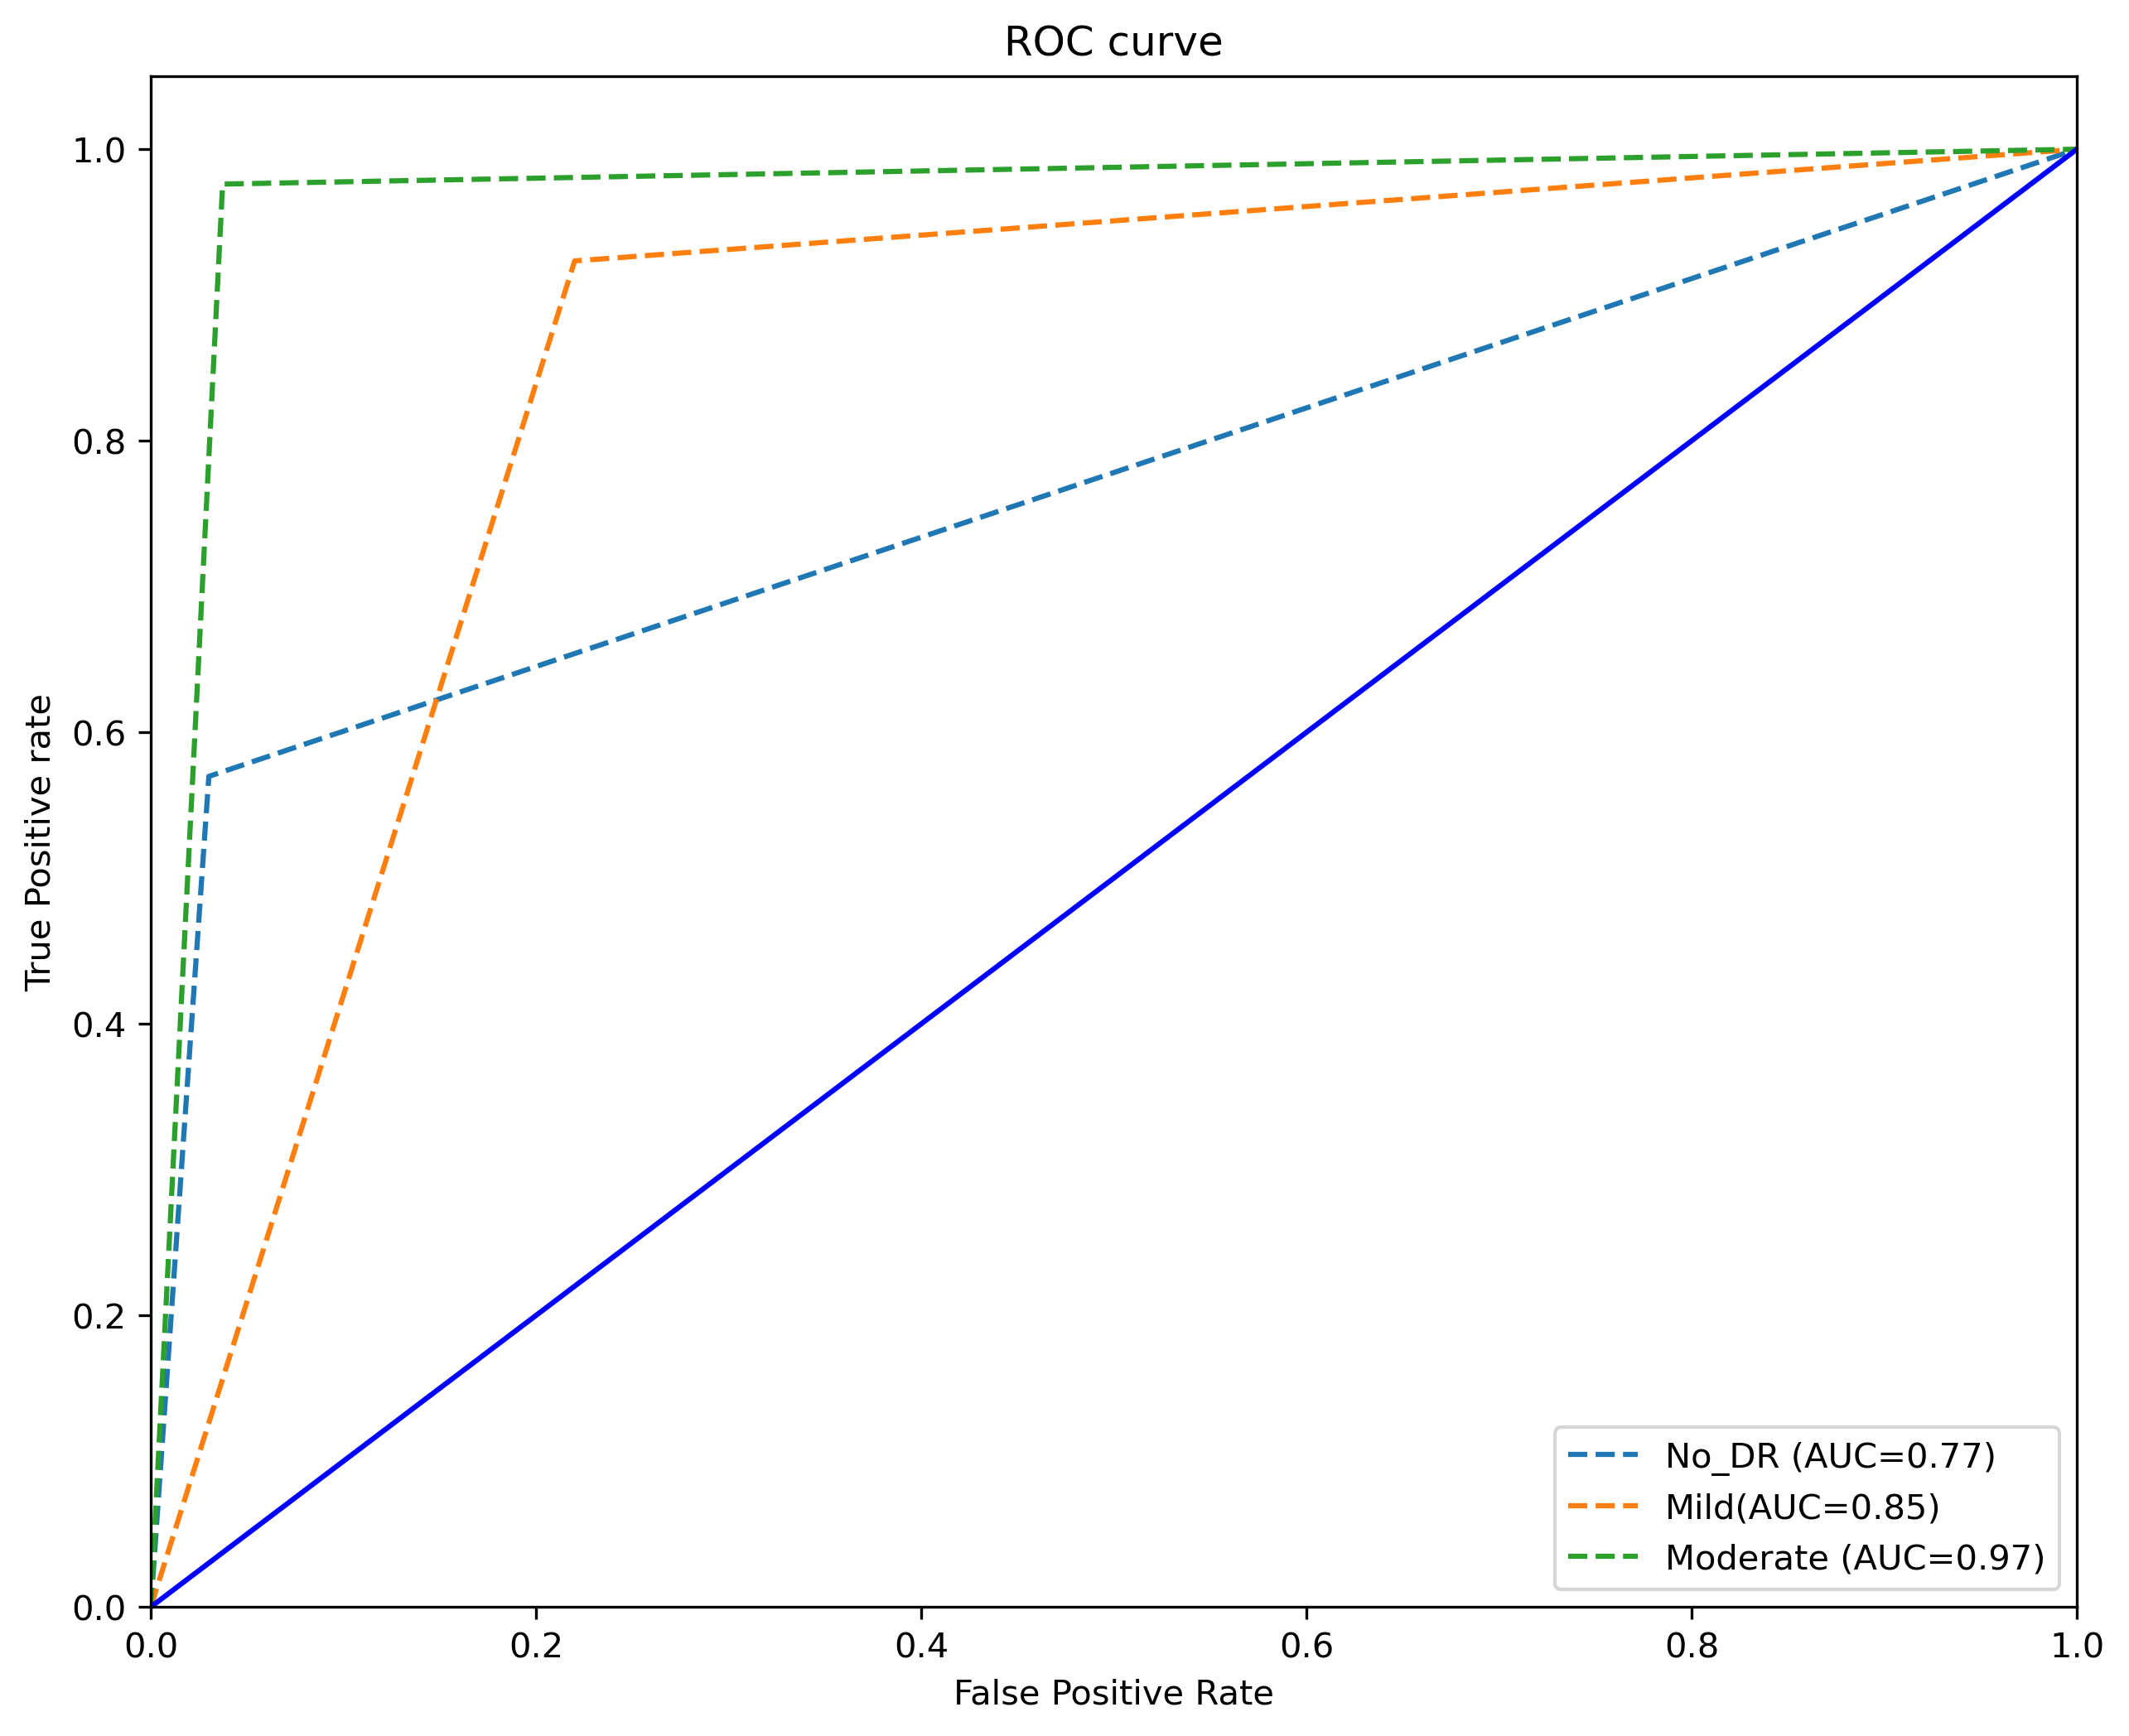

In [39]:
pr = dict()
fpr=dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]
fig=plt.figure(figsize=(10, 8), dpi=300)
for i, in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='No_DR (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Mild(AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Moderate (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Severe (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==4:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Proliferate_DR (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet-79_5.png',dpi=300)

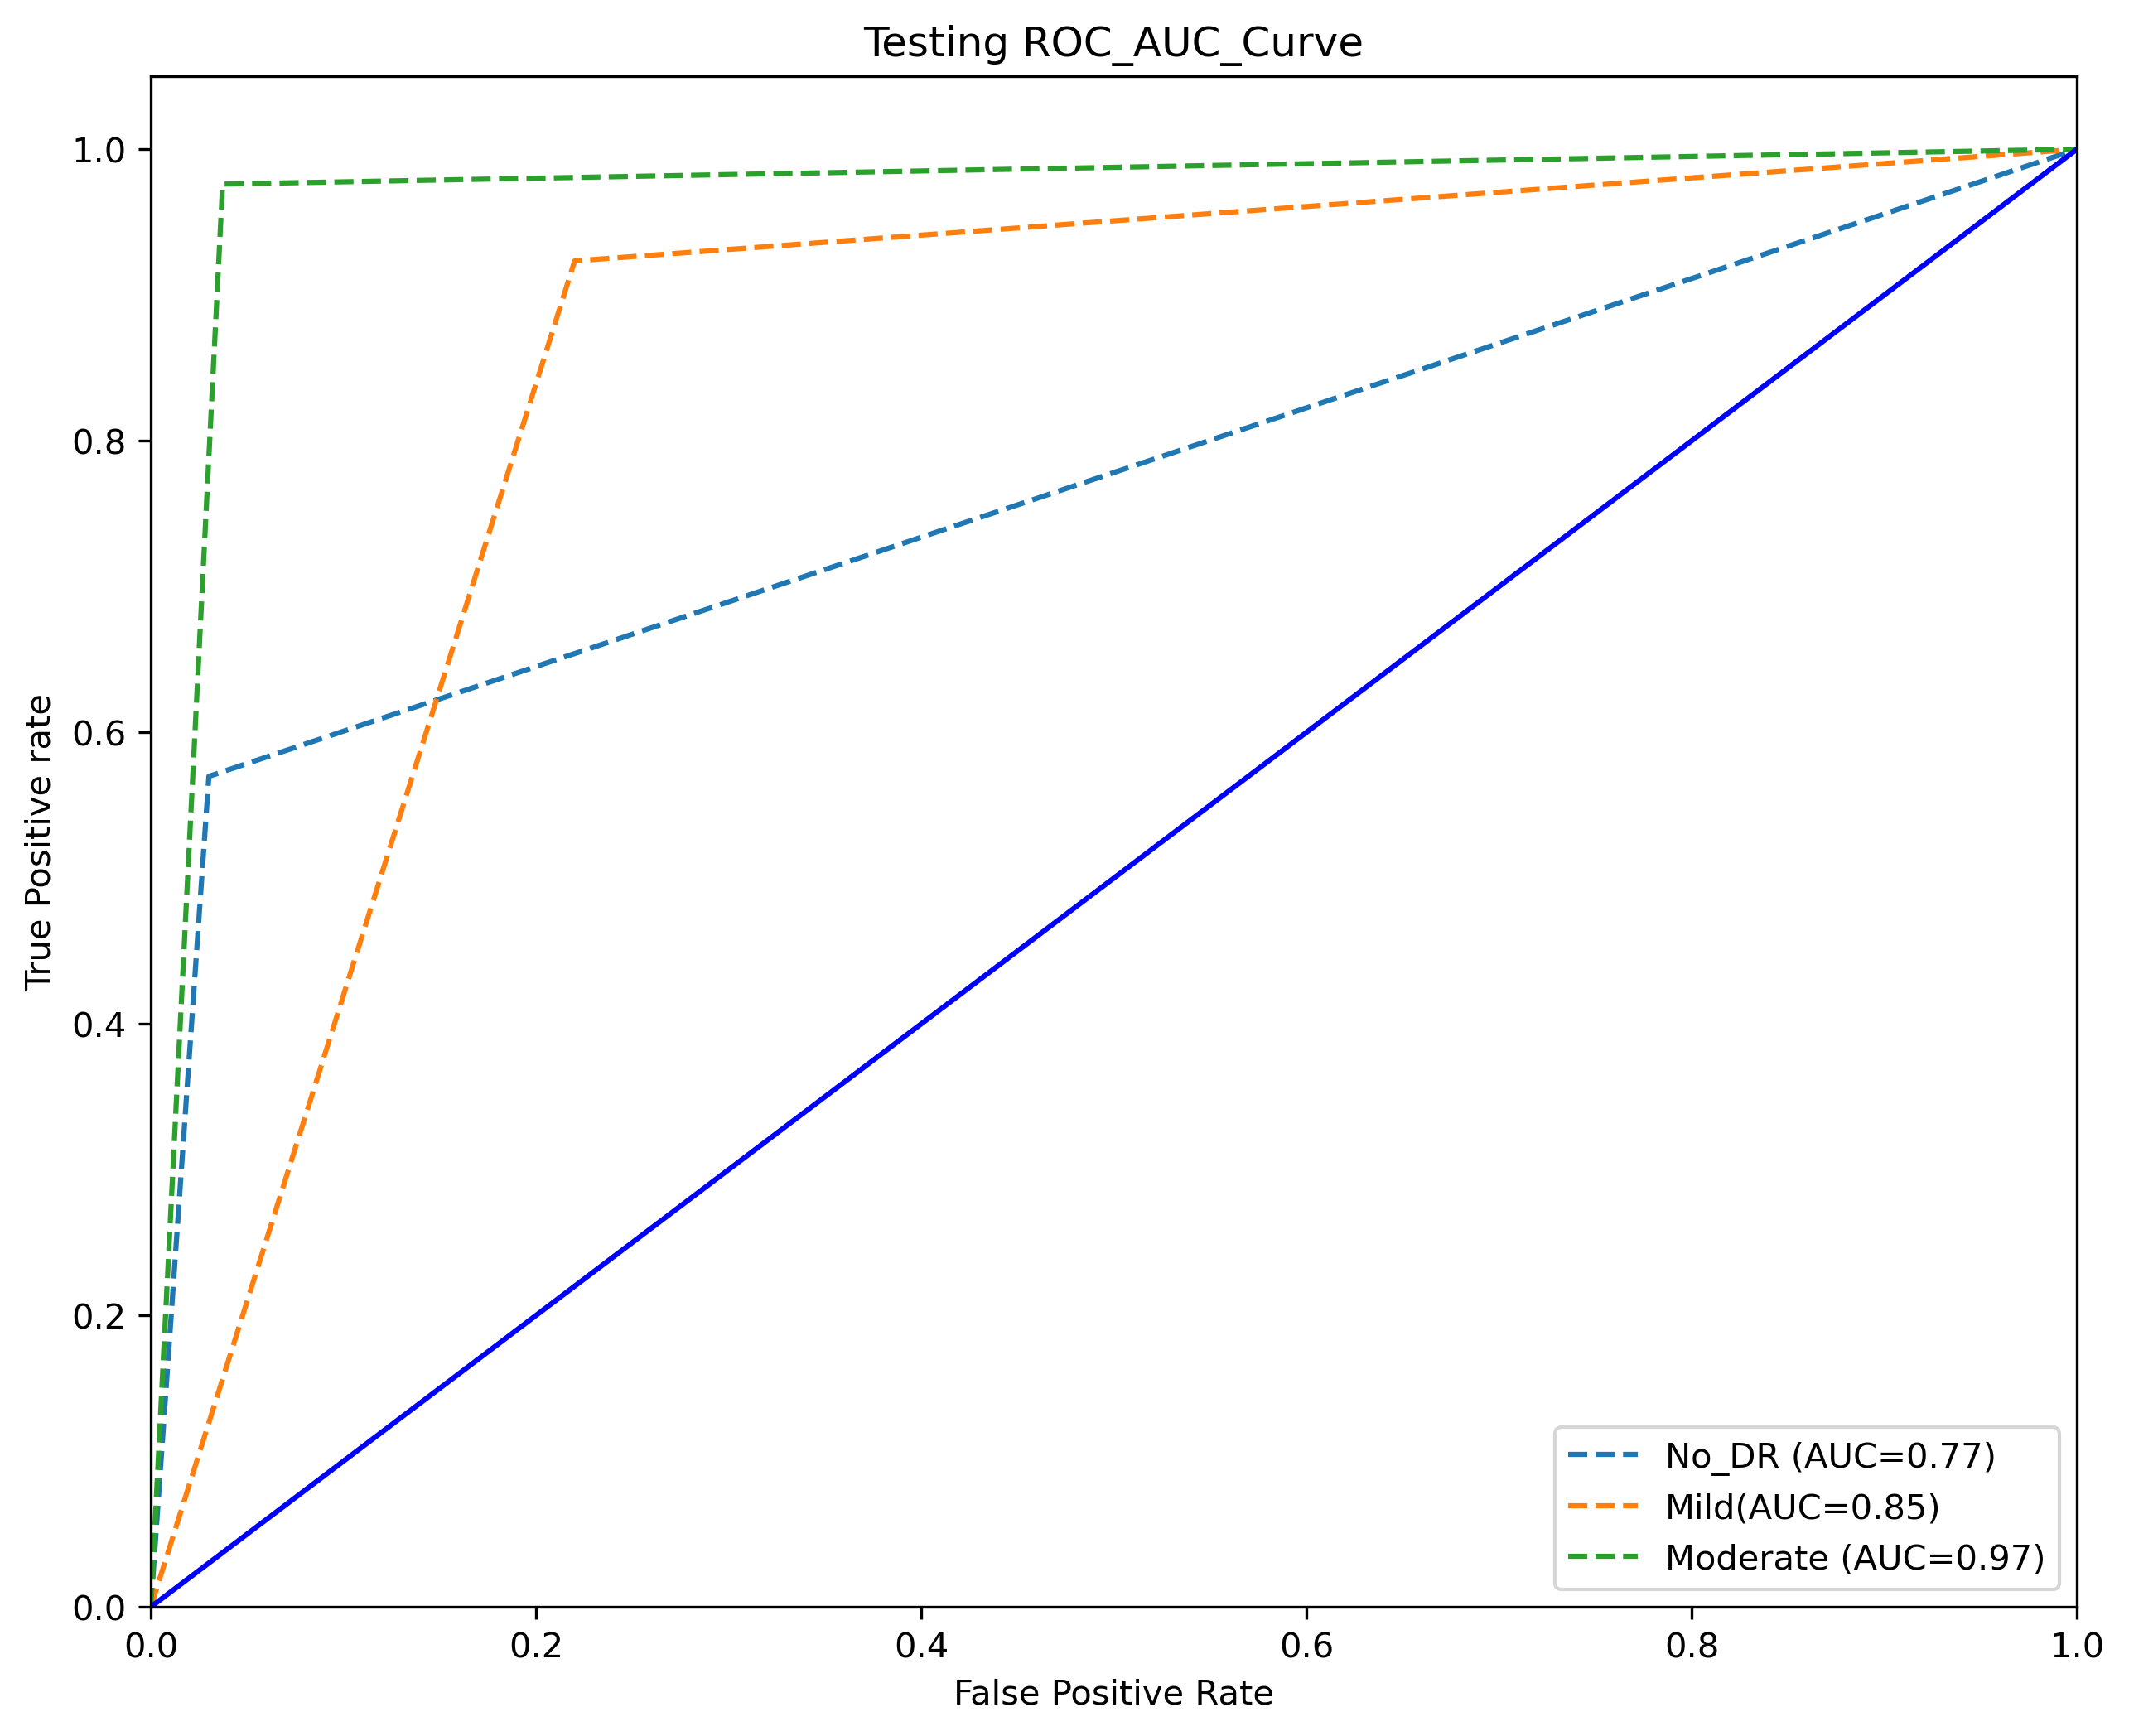

In [40]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]

fig=plt.figure(figsize=(10, 8), dpi=300)
for i in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],pred_labels[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='No_DR (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Mild(AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Moderate (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Severe (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==4:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Proliferate_DR (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Testing ROC_AUC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet_testing-79_5.png',dpi=300)# roc curve for classes